In [2]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import random

# Jumper analysis


## Analysis of jumper homology versus jump-length (julen)

In this analysis, we look at how homology of jumpers varies with jump-length (julen).

1. First, we load into a dataframe the required columns from the TSV file output from `find_jumpers.py`. We can alternatively load in the TSV file that is output from `find_odd_even_homolgy.py`. We immediately sort the dataframe based on homology. 

In [3]:
# Load in homology-sorted homolgy-julen tsv file
## input_file = "../test/dna_1000nt_homology_results_oddEven.tsv"
input_file = "../data/chr20_homology_results_oddEven.tsv"

cols = ["homology", "julen"]
homology_df = pd.read_csv(input_file, usecols=cols, sep="\t").sort_values(by="homology", inplace=False).reset_index(drop=True)

In [4]:
# Inspect the first and last lines of the dataframe.
print(homology_df.head())
print(homology_df.tail())

   homology  julen
0     0.625     44
1     0.625    148
2     0.625    148
3     0.625    122
4     0.625    144
          homology  julen
42936419       1.0     96
42936420       1.0     96
42936421       1.0     96
42936422       1.0    118
42936423       1.0     40


2. The dataframe is sorted from least homology to most homology. We then split our dataframe into 3 equally-sized dataframes with different ranges of homology.

In [5]:
# Split the dataframe into 3 equally-sized dataframes with different homology ranges.
one_third_rows = int(len(homology_df) / 3)
low_homology_df = homology_df.iloc[0 : one_third_rows]
mid_homology_df = homology_df.iloc[one_third_rows : 2*one_third_rows]
high_homology_df = homology_df.iloc[2*one_third_rows : ]

 3. We define a function to plot a histogram with julen on the x-axis and homology count on the y-axis.

In [6]:
# Function for plotting homology as a histogram.
def plot_homology_histogram(df, min_homology, max_homology, bins=120, color="red", threshold_count=200000):
    
    # Plot a histogram of julen.
    n, bins, patches = plt.hist(df["julen"], bins=bins, color=color)
    
    # Annotate bins with counts above threshold_count.
    for count, bin_edge, patch in zip(n, bins, patches):
        if count > threshold_count:
            plt.annotate(f"{bin_edge+1:.0f}", xy=(bin_edge + (bins[1] - bins[0]) / 2, count),
                         xytext=(0, 5), textcoords="offset points", ha="center", va="bottom", color="black")


    # Set the title and axis labels.
    plt.title(f"Jumper distribution (homology {min_homology} - {max_homology})")
    plt.xlabel("Julen distance (nt)")
    plt.ylabel("Count")

    # Display the histogram.
    plt.show()

 4. Lastly, we plot the histograms of each dataframe.

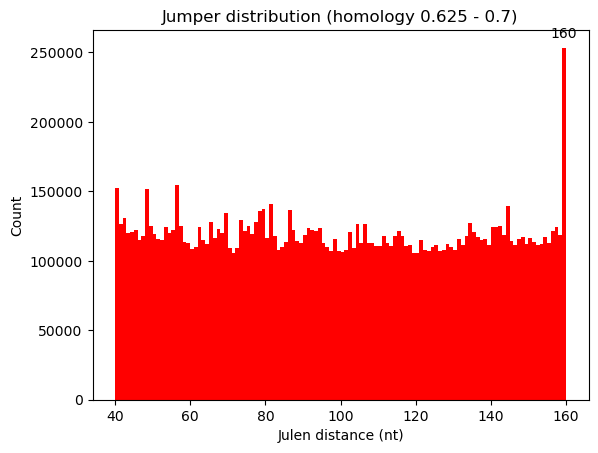

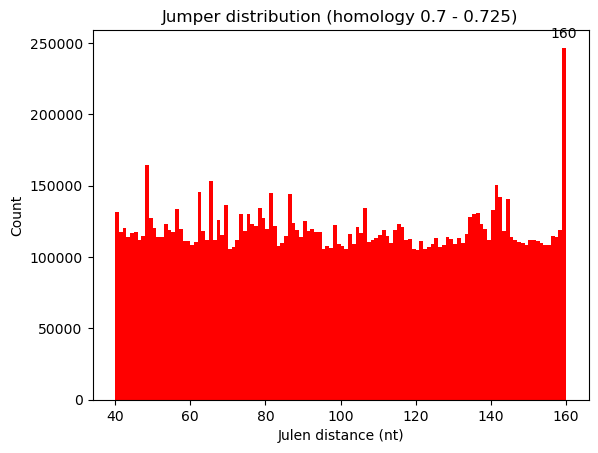

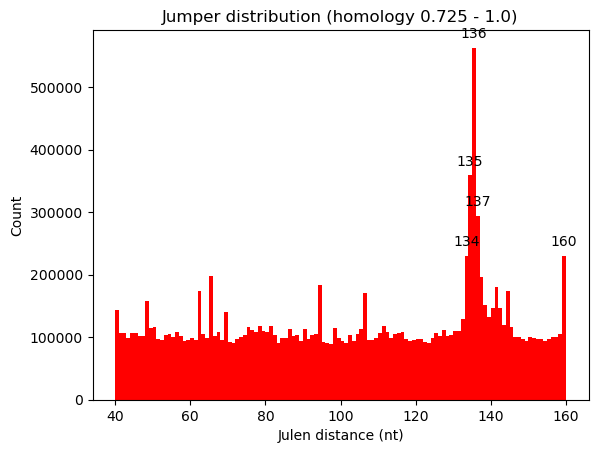

In [7]:
# Plot each of the dataframes.
plot_homology_histogram(low_homology_df, low_homology_df["homology"].min(), low_homology_df["homology"].max())
plot_homology_histogram(mid_homology_df, mid_homology_df["homology"].min(), mid_homology_df["homology"].max())
plot_homology_histogram(high_homology_df, high_homology_df["homology"].min(), high_homology_df["homology"].max())

We observe that for jumpers with high homology, there are many jumpers with a julen of 136 nt.

## Analysis of odd versus even jumper homology

In this analysis, we will look at how the difference in homolgy between even-numbered bases and odd-numbered bases varies with jump-length (julen). 

First, we load in the required columns from the TSV file output from `find_odd_even_homology.py`.

In [8]:
# Load in the required columns from the homology results TSV file.
## ## input_file = "../test/dna_1000nt_homology_results_oddEven.tsv"
input_file = "../data/chr20_homology_results_oddEven.tsv"
cols = ["julen", "homology", "odd_homology", "even_homology", "redif", "abdif"]
odd_even_df = pd.read_csv(input_file, usecols=cols, sep="\t")
odd_even_df.head()

,homology,julen,odd_homology,even_homology,redif,abdif
0,1.000,40,1.00,1.00,0.00,0.00
1,0.975,40,0.95,1.00,0.05,0.05
2,0.950,40,0.95,0.95,0.00,0.00
3,0.925,40,0.90,0.95,0.05,0.05
4,0.900,40,0.90,0.90,0.00,0.00


2. We filter the dataframe to only include jumpers with a homology of greater than or equal to 0.75. We then group the dataframe by julen and calculate the mean relative difference (redif) between even homology and odd homology, as well as the mean absolute difference (abdif).

In [9]:
# Filter the dataframe for homology values greater than or equal to 0.75.
odd_even_df_filtered = odd_even_df[odd_even_df["homology"] >= 0.75]

# Group by julen and calculate the mean relative difference and mean absolute difference.
julen_grouped_df = odd_even_df_filtered.groupby("julen").agg({"redif": "mean", "abdif": "mean"}).reset_index()

# Find high redif and abdif values for annotating plots later.
high_redif_values = julen_grouped_df.loc[julen_grouped_df["redif"] > 0.2, "julen"]
high_abdif_values = julen_grouped_df.loc[julen_grouped_df["abdif"] > 11, "julen"]

In [10]:
julen_grouped_df.head(100)

,julen,redif,abdif
0,40,0.001559,0.095114
1,41,0.000204,0.100292
2,42,0.000045,0.100425
3,43,-0.000124,0.101879
4,44,0.000231,0.102870
...,...,...,...
95,135,0.000194,0.085137
96,136,0.000228,0.087513
97,137,-0.000112,0.092260
98,138,-0.000062,0.093285


3. We define a function to make a bar plot of the mean relative or absolute difference versus julen.

In [11]:
def plot_homology_difference(
        df, 
        value="redif", 
        title="Mean relative difference by julen",
        ylab="Relative difference (Even homology - odd homology)%",
        ylim = [-1, 1],
        annotation_limit = 0.2):
    
    # Set the figure size.
    fig = plt.figure(figsize=(10, 5.5))

    # Color even julens with blue and odd julens with red.
    colors = ["blue" if x % 2 != 0 else "red" for x in df["julen"]]

    # Create a custom legend with specified labels and colors
    blue_patch = plt.Line2D([0], [0], marker="o", color="w", label="Even Julen", markerfacecolor="blue", markersize=10)
    red_patch = plt.Line2D([0], [0], marker="o", color="w", label="Odd Julen", markerfacecolor="red", markersize=10)

    # Create and plot a bar chart of the homology difference versus julen.
    plt.bar(df["julen"], df[value]*100, color=colors, alpha=0.7)
    plt.xlabel("Julen (nt)")
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend(handles=[blue_patch, red_patch])
    plt.ylim(ylim)
    
    # Annotate bars with high redif / abdif values.
    for index, v in enumerate(df[value]):
        if (v >= (annotation_limit / 100)) or (v <= (-1*annotation_limit / 100)):
            plt.text(df["julen"][index], v*100 + 0.01, f"{df['julen'][index+1]}", ha="center", va="bottom", color="black")
    
    
    plt.show()

4. We plot the mean relative difference (calculated as the even homolgy percent - odd homology percent). We color even length julens (i.e. 2,4,6...) as blue, and odd julens as red.

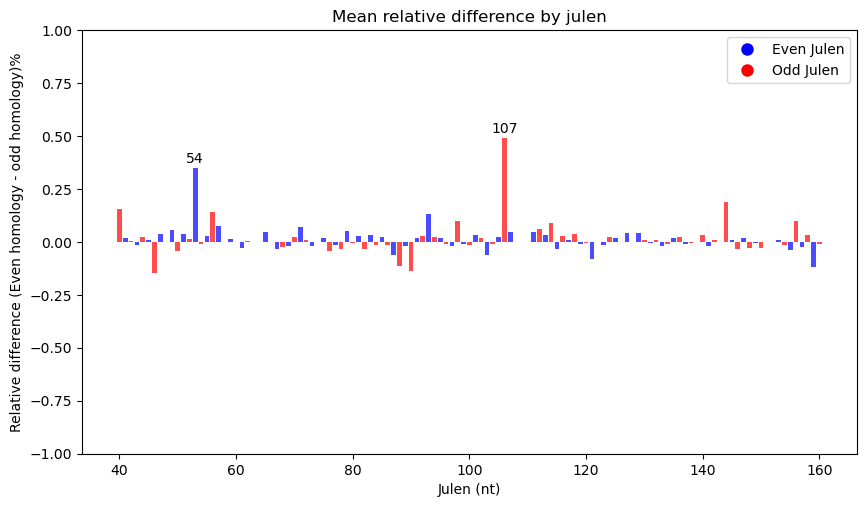

In [12]:
# Plot the relative difference in homology versus julen.
plot_homology_difference(julen_grouped_df, value="redif", annotation_limit = 0.2)

4. We plot the mean absolute difference (calculated as the |redif| ).

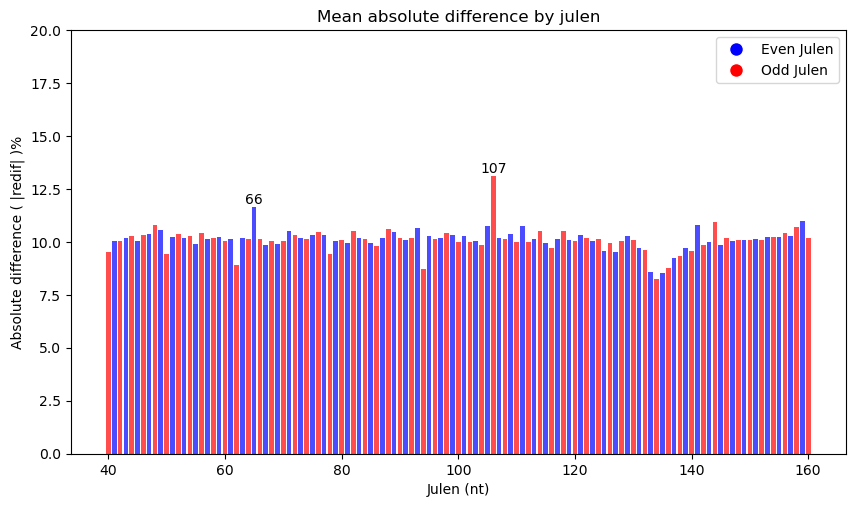

In [13]:
# Plot the absolute difference in homology versus julen.
plot_homology_difference(
    julen_grouped_df, value="abdif", 
    title="Mean absolute difference by julen", ylab="Absolute difference ( |redif| )%", ylim=[0, 20], annotation_limit = 11)

5. To test the significance of the redif peaks, we randomly multiply half of the redif values by -1. We then plot the redif values versus julen.

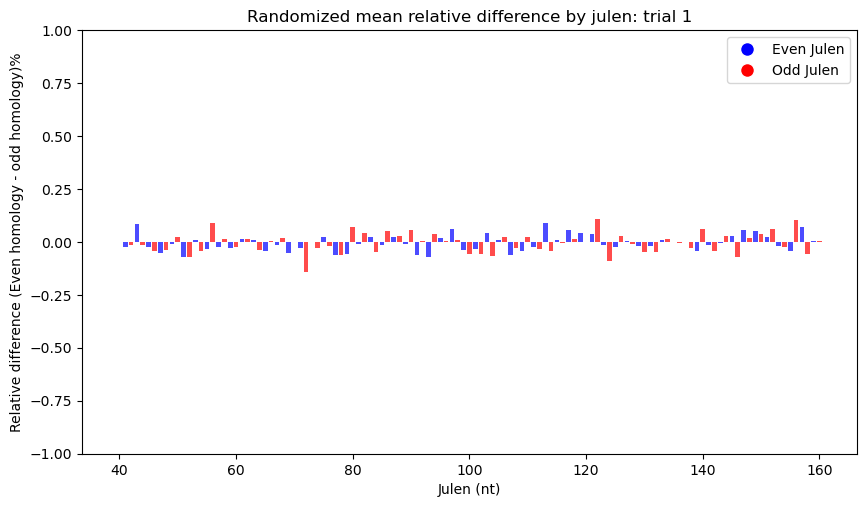

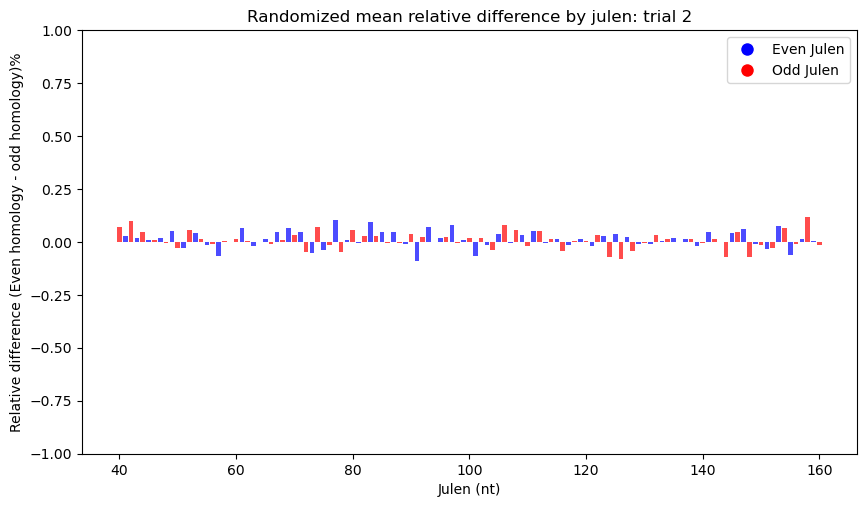

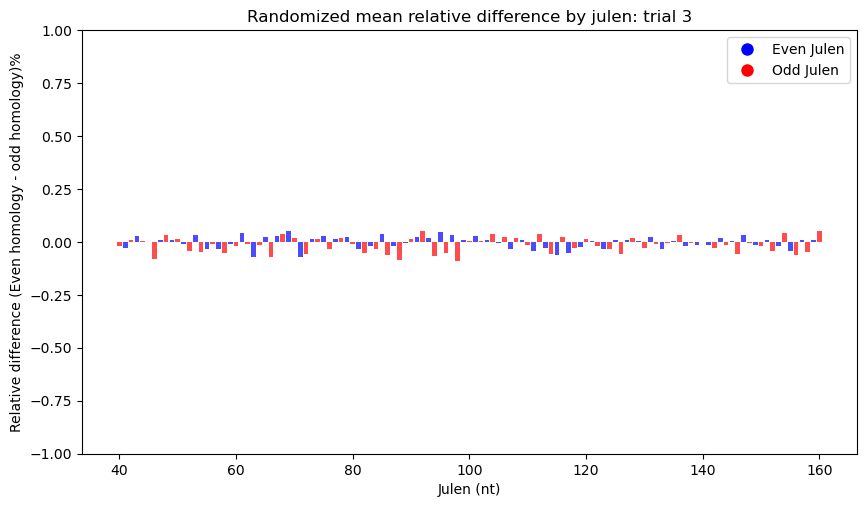

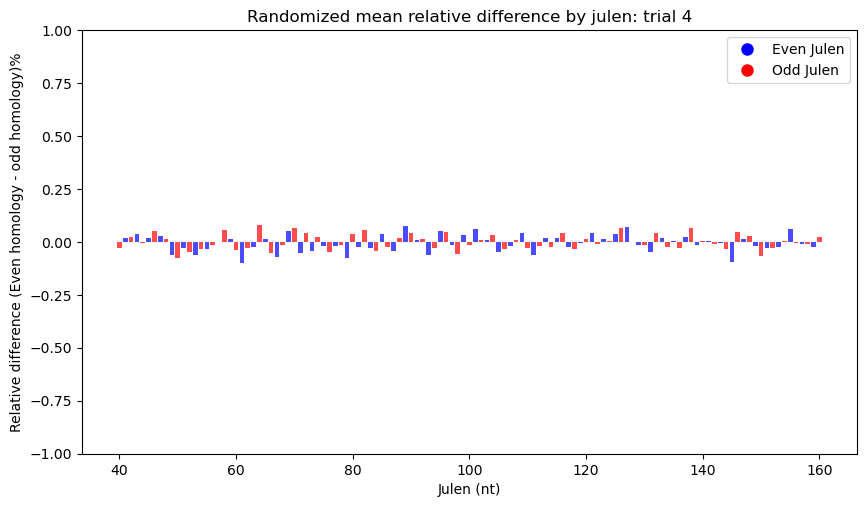

In [14]:
# Iterate for 4 different random seeds.
for seed in range(4):
    random.seed(seed)
    
    # Randomly select half of the rows in the orignial df, and multiply their redif value by -1.
    rows_to_change = random.sample(range(len(odd_even_df_filtered)), len(odd_even_df_filtered)//2)
    
    permuted_df = odd_even_df_filtered.copy().reset_index(drop=True) 
    permuted_df.loc[rows_to_change, 'redif'] *= -1
    
    # Group by julen and calculate the mean relative difference and mean absolute difference.
    julen_grouped_permuted_df = permuted_df.groupby("julen").agg({"redif": "mean", "abdif": "mean"}).reset_index()
    
    # Plot the relative difference in homology versus julen.
    plot_homology_difference(julen_grouped_permuted_df, value="redif", title=f"Randomized mean relative difference by julen: trial {seed+1}")
    

The redif signals are far higher for the real data than for the 4 plots generated from the randomly permuted data. This suggests that the redif signals observed are real.